<a href="https://colab.research.google.com/github/sarangahebbar/DS-Assigments/blob/master/CNN_Skin_Cancer_Image_Analysis_Saranga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import shutil
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive


In [ ]:
## If you are using the data by mounting the google drive, use the following :
drive.mount('/content/gdrive')
main_path='/content/gdrive/MyDrive/CNN_assignment/'
shutil.rmtree(main_path)
gdd.download_file_from_google_drive(file_id='1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs',
                                    dest_path=main_path+'CNN_assignment.zip',
                                    unzip=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Unzipping...Done.


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(os.path.join(main_path,"Skin cancer ISIC The International Skin Imaging Collaboration/Train"))
data_dir_test = pathlib.Path(os.path.join(main_path,"Skin cancer ISIC The International Skin Imaging Collaboration/Test"))

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

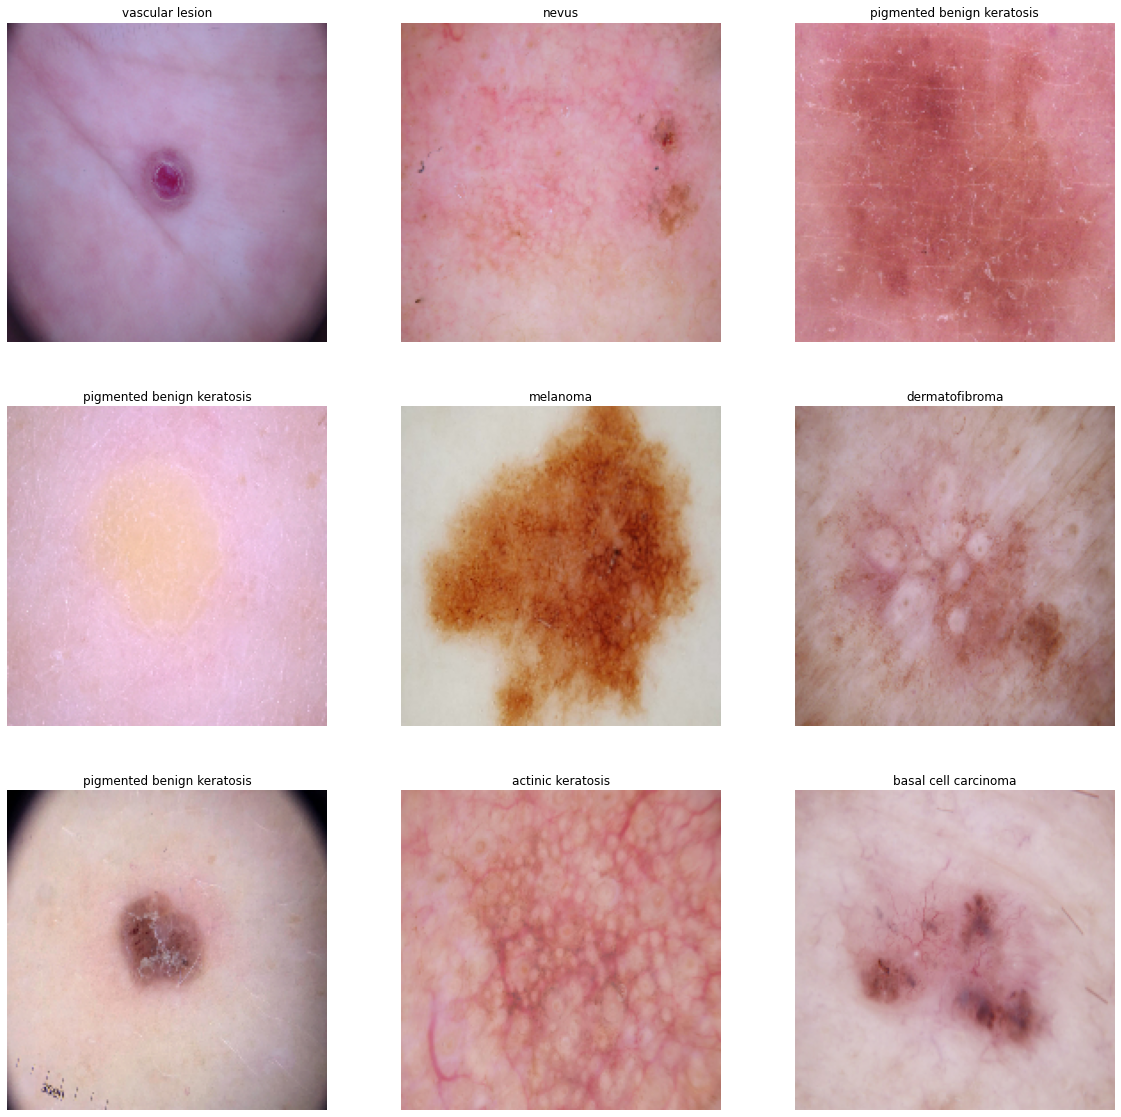

In [ ]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.12712379 0.9995099


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 86ms/step - loss: 2.0699 - accuracy: 0.1883 - val_loss: 2.0337 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0270 - accuracy: 0.2114 - val_loss: 1.9193 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8834 - accuracy: 0.3021 - val_loss: 2.0657 - val_accuracy: 0.3311
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7867 - accuracy: 0.3641 - val_loss: 1.5595 - val_accuracy: 0.4004
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5425 - accuracy: 0.4442 - val_loss: 1.4157 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3810 - accuracy: 0.5185 - val_loss: 1.4468 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3971 - accuracy: 0.5054 - val_loss: 1.7369 - val_accuracy: 0.4273
Epoch 8/20
56

### Visualizing training results

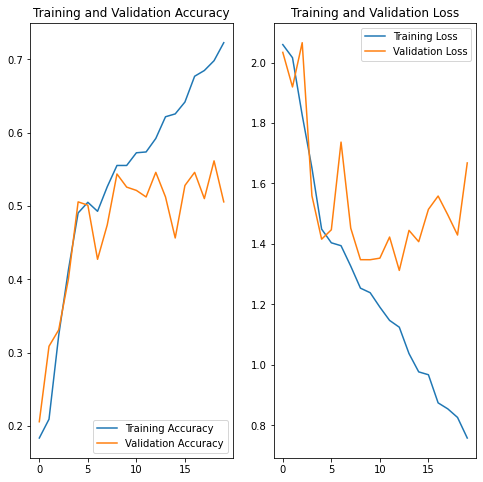

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Inferences:
##### 1) The model seems to be overfitting as the training data is goving over 80% but the validation set is consolidating only between 50-55%
##### 2) Also the Validation loss is not descreasing while the training loss is continuously descreasing. This clearly shows the overfitting scenario

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

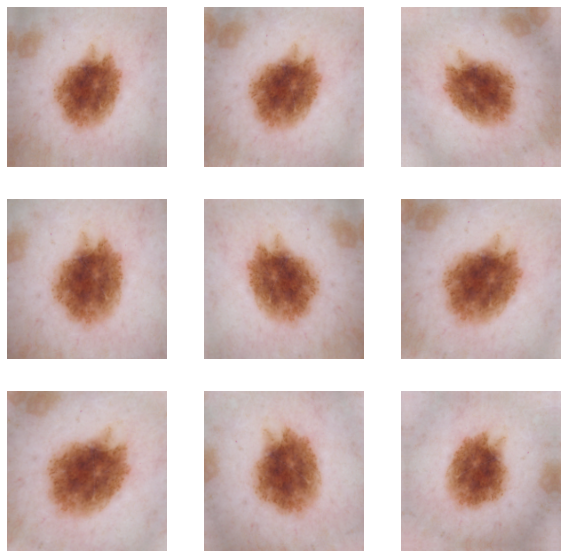

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 32ms/step - loss: 2.1233 - accuracy: 0.1864 - val_loss: 2.0133 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 2.0190 - accuracy: 0.2232 - val_loss: 1.7927 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7146 - accuracy: 0.3857 - val_loss: 1.5883 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5097 - accuracy: 0.4571 - val_loss: 1.4503 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4281 - accuracy: 0.5023 - val_loss: 1.4601 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3430 - accuracy: 0.5107 - val_loss: 1.3810 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3621 - accuracy: 0.5233 - val_loss: 1.4882 - val_accuracy: 0.5011
Epoch 8/20
56

### Visualizing the results

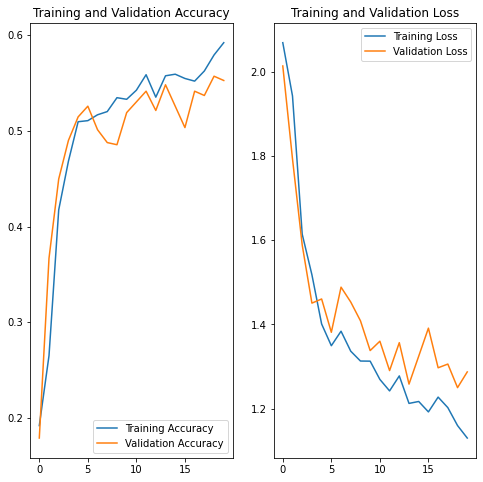

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inference: 
##### > Now, with the dropouts and augmentation added to the model, Training and validation accuracy is consolidating between 50 to 60% 
##### > Since the validation and training loss is also decreasing, this model looks better than the initial model
##### > By the above 2 observations, it shows that the model is underfitting 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
for i in class_names:
  class_image_cnt_train = len(list(data_dir_train.glob(i+'/*.jpg')))
  print('Train Class name :%s \t\t Count: %d' %(i,class_image_cnt_train))

Train Class name :actinic keratosis 		 Count: 114
Train Class name :basal cell carcinoma 		 Count: 376
Train Class name :dermatofibroma 		 Count: 95
Train Class name :melanoma 		 Count: 438
Train Class name :nevus 		 Count: 357
Train Class name :pigmented benign keratosis 		 Count: 462
Train Class name :seborrheic keratosis 		 Count: 77
Train Class name :squamous cell carcinoma 		 Count: 181
Train Class name :vascular lesion 		 Count: 139


#### **Observation:** 
#### - The class Seborrheic Keratosis has the loweest number of samples (77) where as the pigmented benigh keratosis has the highest number of samples (462)
#### - The "pigmented benign keratosis" samples will dominate against the other samples making it imbalanced dataset.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +"/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8F6A834150>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8F0A7C9610>: 100%|██████████| 500/500 [00:18<00:00, 26.83 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8F12162ED0>: 100%|██████████| 500/500 [00:18<00:00, 26.63 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8EFE3C70D0>: 100%|██████████| 500/500 [00:19<00:00, 25.78 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F8F6A973250>: 100%|██████████| 500/500 [01:18<00:00,  6.36 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F8F6027AF50>:   0%|          | 1/500 [00:00<01:25,  5.86 Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F8F6A883250>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8F0B12BA50>:   0%|          | 1/500 [00:00<01:25,  5.87 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8F0A0852D0>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8F0A606FD0>: 100%|██████████| 500/500 [00:41<00:00, 12.09 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8F0A4E7E10>: 100%|██████████| 500/500 [00:18<00:00, 26.88 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8F6A9B15D0>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict = dict(zip(path_list, lesion_list))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train = pathlib.Path(os.path.join(main_path,"Skin cancer ISIC The International Skin Imaging Collaboration/Train"))
data_dir_test = pathlib.Path(os.path.join(main_path,"Skin cancer ISIC The International Skin Imaging Collaboration/Test"))

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train=
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.20),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_22 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_23 (Batc (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 45, 45, 32)      

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 227ms/step - loss: 3.7155 - accuracy: 0.3434 - val_loss: 8.9254 - val_accuracy: 0.1455
Epoch 2/30
169/169 [==============================] - 39s 227ms/step - loss: 1.2075 - accuracy: 0.5568 - val_loss: 5.6864 - val_accuracy: 0.2613
Epoch 3/30
169/169 [==============================] - 39s 227ms/step - loss: 1.0180 - accuracy: 0.6298 - val_loss: 1.6208 - val_accuracy: 0.5308
Epoch 4/30
169/169 [==============================] - 40s 228ms/step - loss: 0.7188 - accuracy: 0.7266 - val_loss: 0.7832 - val_accuracy: 0.7112
Epoch 5/30
169/169 [==============================] - 39s 225ms/step - loss: 0.5671 - accuracy: 0.7918 - val_loss: 0.6913 - val_accuracy: 0.7439
Epoch 6/30
169/169 [==============================] - 40s 228ms/step - loss: 0.4614 - accuracy: 0.8287 - val_loss: 0.6250 - val_accuracy: 0.7832
Epoch 7/30
169/169 [==============================] - 40s 228ms/step - loss: 0.3541 - accuracy: 0.8685 - val_loss: 0.7443 - val_ac

#### **Todo:**  Visualize the model results

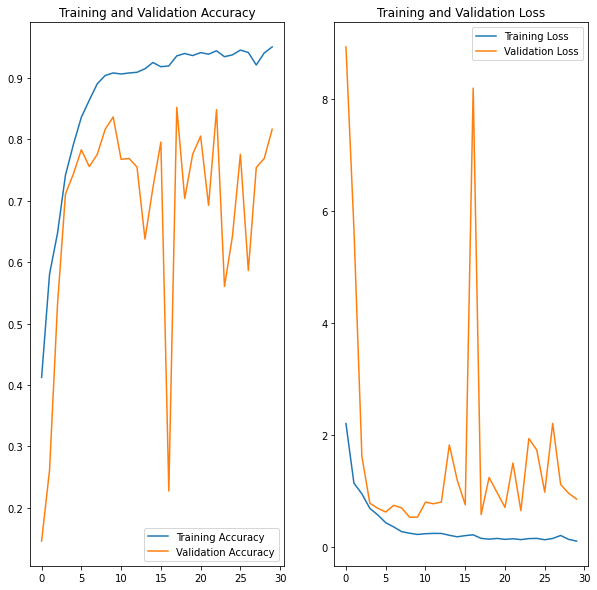

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1) This model has resolved the overfitting/underfitting issue. Both training and validation set is able to provide the accuracy that are close to each other and ranging between 80-89% (validation_set) and 90-95% (training_set)

2) The training loss and validation loss is also stabilized at 0.4-0.6 (validation_set) and at 0.13 (training_set)

### Finally evaluating the built model with the Test dataset

#### The model output on the test dataset is 41.53% accuracy and loss of 5.597

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
model.evaluate(test_ds)

4/4 [==============================] - 4s 13ms/step - loss: 5.5976 - accuracy: 0.4153


[5.597624778747559, 0.41525423526763916]

### Fitting the model with higher epoch = 60

In [ ]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
169/169 [==============================] - 40s 229ms/step - loss: 0.1217 - accuracy: 0.9462 - val_loss: 0.8149 - val_accuracy: 0.8181
Epoch 2/60
169/169 [==============================] - 40s 228ms/step - loss: 0.1018 - accuracy: 0.9518 - val_loss: 0.6303 - val_accuracy: 0.8597
Epoch 3/60
169/169 [==============================] - 40s 229ms/step - loss: 0.1258 - accuracy: 0.9466 - val_loss: 0.9292 - val_accuracy: 0.7966
Epoch 4/60
169/169 [==============================] - 40s 228ms/step - loss: 0.1631 - accuracy: 0.9379 - val_loss: 0.9324 - val_accuracy: 0.7877
Epoch 5/60
169/169 [==============================] - 40s 228ms/step - loss: 0.1388 - accuracy: 0.9453 - val_loss: 0.8832 - val_accuracy: 0.8010
Epoch 6/60
169/169 [==============================] - 39s 227ms/step - loss: 0.1506 - accuracy: 0.9421 - val_loss: 0.9951 - val_accuracy: 0.7966
Epoch 7/60
169/169 [==============================] - 40s 228ms/step - loss: 0.1645 - accuracy: 0.9395 - val_loss: 0.7792 - val_ac

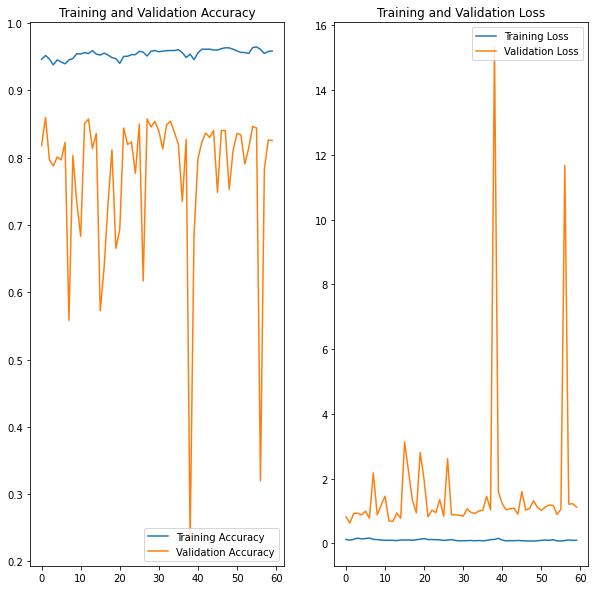

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The epoch=60 for the same model with 6 layers ( 4 Convolution and 2 Dense) has given the good accurary 

##### Training Accuracy - consistantly 94-96%
##### Validation accuracy - in the range of 80-85% (sporadically dipping to a lower value)